Get today's Notebook at: www.eng.mu.edu/ccl/c4c

---
## Make a copy of this Notebook

- Go to `File > Save a copy in Drive`
  - You may want to change the default name to `your-name-Friday-project.ipynb`
- Now, follow the instructions and start coding!


## Goal of the project

Over the entire week, we talked about AQI and calculated some components of climate-related data using Python. Today we will use real monitoring data to calculate AQI for a time and place (in Wisconsin) of your chosing.

1. Download data for a day for a location in Wisconsin from the Department of Natural Resources website.
2. We will also provide you a `prepare_data()` function like we did for the earlier project to clean the data for your calculation.
  - The input into the function will just be the filename
3. Use `numpy` module to extract the appropriate data from this DataFrame to calculate AQI based on PM2.5 concentration.
4. Write a function that calculates AQI using the formula given below
  - The function must take in the measured concetration ($C$) as input and return the calculated AQI
5. Plot the AQI vs time using Matplotlib

### Extra Practice
- Calculate and plot AQI using Ozone as pollutant
- Plot how the temperature and relative humidity varied hourly through the day

---




## Calculating AQI
Air Quality Index is calculated separately for each pollutant based on the concentration of that specific pollutant. Remember we talked about common pollutants? For air quality, the ones that are used are: Ozone, PM2.5, PM10, CO (carbon monoxide), SO2 (sulfer dioxide), and NO2 (nitric oxide). Among these, Ozone and PM are the most important.

In the final project, we will calculate AQI based on PM2.5 concentration for a week somewhere in Wisconsin.

### AQI Formula

The AQI is calculated using the formula below

$$AQI = I_1 + \frac{I_2 - I_1}{B_2 - B_1}\times\left(C-B_1\right)$$

Here, **$C$ is the concentration of the pollutant** (usually averaged over a specified period).

**$I_1$, $I_2$, $B_1$, and $B_2$ are obtained from a table based on the value of $C$.** These tables for *PM2.5* and *Ozone* are listed below

#### For **PM2.5**


|Range| $B_1$ | $B_2$ | $I_1$ | $I_2$ |
|----|---|----|----|----|
|0 < $C$ <= 9| 0 | 9.0| 0|50|
|9 < $C$ <= 35.4| 9.1 | 35.4| 51|100|
|35.4 < $C$ <= 55.4|35.5 | 55.4| 101|150|
|55.4 < $C$ <= 125.4|55.5 | 125.4 | 151|200|
|125.4 < $C$ <= 225.4|125.5 | 225.4 | 201 |300|
|225.4 < $C$ |225.5 | 325.4 | 301 | 500 |


#### For **Ozone**

|Range| $B_1$ | $B_2$ | $I_1$ | $I_2$ |
|---|----|----|----|----|
|0 < $C$ <= 0.125| 0 | 0.125| 0|100|
|0.125 < $C$ <= 0.165| 0.125 | 0.164| 101|150|
|0.165 < $C$ <= 0.205|0.165 | 0.204 | 151|200|
|0.205 < $C$ <= 0.425|0.205 | 0.424 | 201 |300|
|0.425 < $C$  |0.405 | 0.604 | 301 | 500 |


---




## Getting the data

- Go to [Wisconsin Air Quality Monitoring Data Website](https://airquality.wi.gov/report/SingleStationReport).

*On left pane*
- Pick a county
- Pick a owner (preferably, *DNR - Active*)
- Select a station
   - Make sure that this station has PM2.5 data
- Select All monitors

*On right pane*
- Select *Excel* under report view
- Select *Daily* under period
- Choose a day by changing the *From date*
- Under type, select *Average*
- Select *1 Hour* for both from and to time base

Then click *DISPLAY*. This will download the data for the selected week.

Now use this downloaded data for your project

---


## `prepare_data()` function

Run this block of code first. Do not modify it.

In [ ]:
###_______________________________________###
###      RUN THIS BLOCK FIRST             ###
###_______________________________________###
### DO NOT MODIFY THIS CODE               ###
### THIS CODE CONTAINS THE FUNCTION NEEDED###
### TO PREPARE DATA                       ###
###_______________________________________###
###     RUN THIS BLOCK FIRST              ###
###_______________________________________###


# The function to prepare data for the project
# First read the downloaded file into a DataFrame
# Then call this function

def prepare_dnr_data_station_report(file_path):

  import pandas as pd

  data = pd.read_excel(file_path)

  #
  # Drop row number 0
  data = data.drop(0).reset_index(drop=True)

  # Combine rows 0 and 1 to create a new header
  new_header = data.iloc[0] + ' (' + data.iloc[1] + ')'
  new_header = new_header.str.replace(' \(nan\)', '', regex=True).str.strip() # Clean up ' (nan)' from combined header
  data.columns = new_header

  # Drop the original header rows (now rows 0 and 1)
  data = data.drop([0, 1]).reset_index(drop=True)

  # Convert the first column to datetime objects, coercing errors
  data['DateTime'] = pd.to_datetime(data.iloc[:, 0], errors='coerce')

  data['Time'] = pd.to_datetime(data['DateTime'])
  # data['Hour'] = data['Time'].dt.hour
  # data['Minute'] = data['Time'].dt.minute
  # data['Second'] = data['Time'].dt.second

  # Calculate elapsed time in seconds
  start_time = data['Time'].iloc[0]
  data['ElapsedTime[s]'] = (data['Time'] - start_time).dt.total_seconds()
  data['ElapsedTime[hrs]'] = data['ElapsedTime[s]'] / 3600
  data = data.set_index('Time')

  # Keep only rows with valid datetime entries
  data = data.dropna(subset=['DateTime'])

  # Set 'DateTime' as the index
  data = data.set_index('DateTime')


  new_column_names = {
              'date time': 'Time',
              'NO (ppb)': 'NO[PPB]',
              'NO2 (ppb)': 'NO2[PPB]',
              'NOx (ppb)': 'NOx[PPB]',
              'Outdoor tempearture in deg (degF)': 'T[F]',
              'Ozone (ppb)': 'Ozone[PPB]',
              'SO2 (ppb)': 'SO2[PPB]',
              'Wind Direction (Degrees)': 'WindDir[Degrees]',
              'Wind Speed (mph)': 'WindSpeed[MPH]',
              'PM COARSE (10-2.5) (ug/m3 (LC))':'PM_coarse[ug/m3]',
              'PM10 (ug/m3 (25C))':'PM10[ug/m3]',
              'PM2.5 (ug/m3 (LC))':'PM2.5[ug/m3]',
              'CO (ppm)': 'CO[ppm]',
              'PM2.5 (ug/m3)':'PM2.5[ug/m3]',
              'PM10 (ug/m3)':'PM10[ug/m3]',
              'Relative Humidity (%RH)': 'RH',
              'NOy (ppb)': 'NOy[PPB]',
              'NOy - NO (ppb)': 'NOy-NO[PPB]',
              'PRECIPITATION - RAIN/MELT PCPT (inches)': 'Rain[inches]',
              'PRECIPITATION - SNOW PCPT (inches)': 'Snow[inches]',
              'OZONE (ppb)': 'Ozone[PPB]'
          }

  # Rename the columns present in the DataFrame
  data = data.rename(columns={k: v for k, v in new_column_names.items() if k in data.columns})

  data = data.drop(columns=[float('nan')])

  return data

---
## Now your code starts

In [ ]:
df["Ozone[PPB]"].max()

36.4

In [ ]:
df["Ozone[PPB]"].min()

19.8

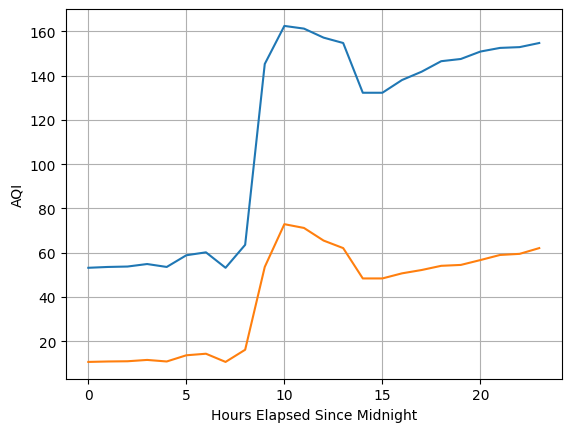

In [ ]:
# Final Project
import numpy as np
import matplotlib.pyplot as plt

df = prepare_dnr_data_station_report("Horicon Wildlife Area (2).xlsx")
Time = np.array(df["ElapsedTime[hrs]"])
Temp = np.array(df["T[F]"])
PM2_5 = np.array(df["PM2.5[ug/m3]"])
RH = np.array(df["RELATIVE HUMIDITY (%RH)"])
Ozone = np.array(df["Ozone[PPB]"])

AQI_list = list()

def AQI_fun(C):
  if 0 < C <= 9:
    B1 = 0
    B2 = 9
    I1 = 0
    I2 = 50
  elif 9 < C <= 35.5:
    B1 = 9.0
    B2 = 35.5
    I1 = 50
    I2 = 100
  elif 35.5 < C <= 55.5:
    B1 = 35.5
    B2 = 55.5
    I1 = 100
    I2 = 150
  elif 55.5 < C <= 125.5:
    B1 = 55.5
    B2 = 125.5
    I1 = 150
    I2 = 200
  elif 125.5 < C <= 225.5:
    B1 = 125.5
    B2 = 225.5
    I1 = 200
    I2 = 300
  else:
    B1 = 225.5
    B2 = 325.5
    I1 = 300
    I2 = 500

  AQI = I1 + (I2-I1)/(B2-B1)*(C-B1)
  return AQI

for i in PM2_5:

  AQI_result = AQI_fun(i)
  AQI_list.append(AQI_result)


plt.plot(Time, AQI_list)
plt.grid()
plt.xlabel("Hours Elapsed Since Midnight")
plt.ylabel("AQI")
plt.plot(Time,PM2_5)

Text(0, 0.5, 'Temperature [F]')

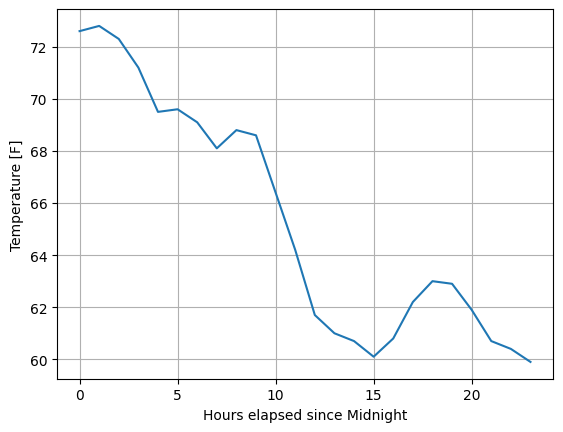

In [ ]:
plt.plot(Time, Temp)
plt.grid()
plt.xlabel("Hours elapsed since Midnight")
plt.ylabel("Temperature [F]")

Text(0, 0.5, 'Relative Humidity')

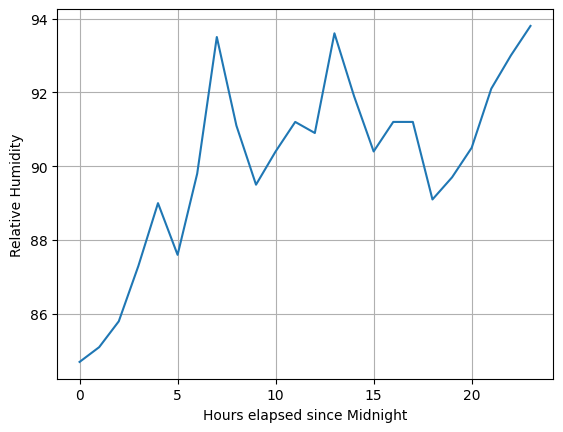

In [ ]:
plt.plot(Time, RH)
plt.grid()
plt.xlabel("Hours elapsed since Midnight")
plt.ylabel("Relative Humidity")

Text(0, 0.5, 'AQI')

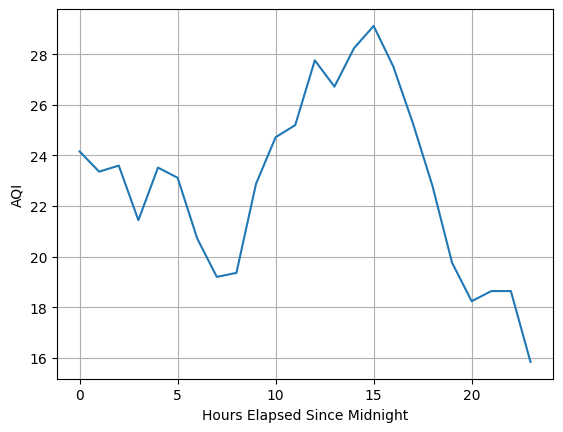

In [ ]:
AQI_list_ozone = list()

def AQI_fun_ozone(C):
  if 0 < C <= 125:
    B1 = 0
    B2 = 125
    I1 = 0
    I2 = 100
  elif 125 < C <= 165:
    B1 = 125
    B2 = 165
    I1 = 100
    I2 = 150
  elif 165 < C <= 205:
    B1 = 165
    B2 = 205
    I1 = 150
    I2 = 200
  elif 205 < C <= 405:
    B1 = 205
    B2 = 405
    I1 = 200
    I2 = 300
  else:
    B1 = 405
    B2 = 604
    I1 = 300
    I2 = 500

  AQI = I1 + (I2-I1)/(B2-B1)*(C-B1)

  if AQI <0:
    print(f"C:{C}, I1:{I1}, I2:{I2}, B1:{B1}, B2:{B2}, AQI:{AQI}")

  return AQI

for i in Ozone:

  AQI_result_ozone = AQI_fun_ozone(i)
  AQI_list_ozone.append(AQI_result_ozone)

plt.plot(Time, AQI_list_ozone)
plt.grid()
plt.xlabel("Hours Elapsed Since Midnight")
plt.ylabel("AQI")